<a href="https://colab.research.google.com/github/kevgam/CAS_IE_Information_Retrieval/blob/main/IR_Test_NEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vorbereitung des Datensatzes in Spark

Unser ursprünglicher Spotify-Datensatz, der über [Kaggle](https://www.kaggle.com/discussions/accomplishments/522912) verfügbar ist, umfasste fast eine Million Datensätze. Aufgrund der Grösse des Datensatzes hatten wir bei der Verarbeitung Performanceprobleme. Daher haben wir den Datensatz zunächst in der Spark-Umgebung der ZHAW vorverarbeitet.


Nach dem Standardlogin (inkl. sc.stop() am Schluss) gemäss Anleitung der ZHAW haben wir folgende Schritte ausgeführt:

### Installation und Test der Umgebung

```python
# Installation des notwendigen Pakets
sparky.installpackage('langdetect')

# Alternativ mit pip
pip install langdetect

# Test der RDD-Funktionalität
import os
liste = range(16)
rdd = sc.parallelize(liste)
print(rdd.collect())
print(rdd.glom().collect())

# Überprüfen, ob alle Worker die notwendige Software installiert haben
if len(list(filter(lambda x: x == [], rdd.glom().collect()))):
    raise SystemExit("Nicht gut - einige Worker bleiben ohne Softwareinstallation.")

# Testfunktion für Abhängigkeiten
def testdep(ignore_arg):
    ip = "160.85.252.66"  # Beispiel-IP
    try:
        import lxml
    except:
        return f"lxml FAILED! @ {ip}"
    else:
        return f"lxml worked @ {ip}"

# Installation von Abhängigkeiten
import subprocess
def installdeps(ignore_arg):
    p = subprocess.run("pip install lxml", shell=True, stdout=subprocess.PIPE)
    return p.stdout.decode()

# Ausführen der Installation und Tests
rdd.map(installdeps).collect()
rdd.map(testdep).collect()


### Laden und Verarbeiten der Daten

```python
# Das File wurde vorgängig in unseren Ordner auf dem Server kopiert
filepath = 'songs_with_attributes_and_lyrics.csv'

# Laden der CSV-Datei
import pandas as pd
dfs = pd.read_csv(filepath)

# Spark DataFrame laden
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
dfs = spark.read.csv(filepath, header=True, inferSchema=True)


### Sprache erkennen und Fortschritt protokollieren

```python
from langdetect import detect

# Funktion zur Erkennung der Sprache mit Fortschrittsanzeige
def detect_language_with_progress(partition):
    total_rows = 0
    for row in partition:
        try:
            lang = detect(row['lyrics'])
            yield (row['lyrics'], lang)  # Rückgabe: Originaltext und erkannte Sprache
        except Exception:
            yield (row['lyrics'], 'unknown')
        total_rows += 1
        if total_rows % 1000 == 0:  # Fortschritt alle 1000 Zeilen anzeigen
            print(f"Processed {total_rows} rows in this partition")

# RDD-Transformationen anwenden
rdd = dfs.rdd.mapPartitions(detect_language_with_progress)

# Zurück in ein DataFrame umwandeln
schema = StringType()
result = rdd.toDF(["lyrics", "lyrics_language"])

# Fortschritt anzeigen
result.show()


### Ergebnisse speichern

```python
# Als Excel-Datei speichern
output_path = './processed_songs_with_lyrics.xlsx'
dfs.to_excel(output_path, index=False)
print(f"DataFrame saved to: {output_path}")

# Als CSV-Datei speichern
csv_output_path = './processed_songs_with_lyrics.csv'
dfs.to_csv(csv_output_path, index=False)
print(f"DataFrame saved as CSV file to: {csv_output_path}")


### Filterung und Speicherung der englischen Texte

```python
# Zeilen filtern, in denen die Sprache Englisch ist
dfs_en = dfs[dfs['lyrics_language'] == 'en']

# Gefilterte Daten als Excel- und CSV-Datei speichern
dfs_en.to_excel('./processed_songs_filtered_lyrics_en.xlsx', index=False)
dfs_en.to_csv('./processed_songs_filtered_lyrics_en.csv', index=False)

print("Filtered DataFrame saved as 'filtered_lyrics_en.xlsx' and 'filtered_lyrics_en.csv'")


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Herausfiltern der Datensätze ohne Albumnamen

```python
# Installation pandas und openpyxl
!pip install pandas openpyxl

import pandas as pd

# Laden der CSV-Datei
file_path = "/content/drive/MyDrive/ie_information_retrieval_dataset/processed_songs_filtered_lyrics_en.csv"
df = pd.read_csv(file_path)

# Filtern aller Zeilen, bei denen 'album_name' nicht NaN ist
df_filtered = df.dropna(subset=['album_name'])

# Speichern der Datei als CSV
output_file_path = '/content/drive/MyDrive/ie_information_retrieval_dataset/processed_songs_filtered_lyrics_with_album_name.csv'
df_filtered.to_csv(output_file_path, index=False)


In [1]:
# Installation der benötigten Bibliotheken
!pip install pandas openpyxl

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:


# Lade die Excel-Datei
file_path = "/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_filtered_lyrics_en.xlsx"
df = pd.read_excel(file_path)

# Entferne die Spalten 'id' und 'album_name'
df = df.drop(columns=['id', 'album_name', 'lyrics_language'], errors='ignore')

# Entferne alle Datensätze, bei denen 'duration_ms' kleiner als 240000 (4 Minuten) oder größer als 300000 (5 Minuten) ist
df = df[(df['duration_ms'] >= 240000) & (df['duration_ms'] <= 300000)]

# Entferne Sonderzeichen in den Spalten 'name' und 'artists'
# Sonderzeichen inkl. [] werden entfernt
df['name'] = df['name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
df['artists'] = df['artists'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

# Filtere alle Zeilen, bei denen 'name' NaN ist
df = df.dropna(subset=['name'])

# Filtere alle Zeilen, bei denen 'artists' NaN ist
df = df.dropna(subset=['artists'])

# Entferne Duplikate basierend auf der Kombination aus 'name' und 'artists'
df = df.drop_duplicates(subset=['name', 'artists'])

# Sicherstellen, dass die Spalte 'lyrics' nur String-Werte enthält
df = df[df['lyrics'].apply(lambda x: isinstance(x, str))]

# Entferne Zeilenumbrüche innerhalb der 'lyrics' Spalte
df['lyrics'] = df['lyrics'].apply(lambda x: str(x).replace('\n', ' ').replace('\r', ' ') if isinstance(x, str) else x)

# Setze die 'lyrics'-Spalte in Anführungszeichen
df['lyrics'] = df['lyrics'].apply(lambda x: f'"{x}"' if isinstance(x, str) else x)

# Entferne Duplikate basierend auf der Kombination aus 'duration_ms' und 'lyrics'
df = df.drop_duplicates(subset=['duration_ms', 'lyrics'])

# Speichere die bereinigten Daten als CSV-Datei
output_csv_path = '/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_filtered_lyrics_bereinigt.csv'
df.to_csv(output_csv_path, index=False)

print(f"Bereinigte CSV-Datei wurde gespeichert unter: {output_csv_path}")


ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
# NLTK-Resourcen herunterladen
nltk.download('punkt')
nltk.download('stopwords')

# DataFrame laden
df = pd.read_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_filtered_lyrics_bereinigt.csv')

# Sicherstellen, dass die Spalte 'lyrics' keine fehlenden Werte enthält und Strings sind
df['lyrics'] = df['lyrics'].fillna('').astype(str)

# Funktion zur Textbereinigung
def preprocess_text(text):
    if not isinstance(text, str):  # Sicherstellen, dass die Eingabe ein String ist
        text = str(text)
    tokens = word_tokenize(text.lower())  # Tokenisierung & Kleinschreibung
    tokens = [word for word in tokens if word.isalpha()]  # Sonderzeichen/Zahlen entfernen
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Stopwörter entfernen
    return tokens  # Rückgabe als Liste von Tokens

# Bereinigte Tokens in neuer Spalte speichern
df['clean_lyrics'] = df['lyrics'].apply(preprocess_text)

# Ergebnisse speichern
df.to_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_without_stopwords.csv', index=False)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# DataFrame laden
df = pd.read_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_without_stopwords.csv')

# Entferne Duplikate in 'clean_lyrics'
df = df.drop_duplicates(['clean_lyrics'])

# Filtere alle Zeilen, bei denen 'clean_lyrics' NaN ist
df = df.dropna(subset=['clean_lyrics'])

# Ergebnisse speichern
df.to_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_without_duplicates.csv', index=False)




In [ ]:
display(df)

,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,B Movie Box Car Blues Live,The Blues Brothers Joe Gastwirt,0.606,0.819,9,-8.281,1,0.0696,0.564000,0.004040,0.9590,0.5040,93.307,244400,"""Caught a ride into South Dakota With two gir...","['caught', 'ride', 'south', 'dakota', 'two', '..."
1,BabyRock Rock,Clorofila,0.692,0.900,8,-7.059,1,0.0279,0.014300,0.432000,0.1090,0.9510,126.038,280107,"""I can make a choice and never really have a ...","['make', 'choice', 'never', 'really', 'doubt',..."
2,Boom,MY FIRST STORY,0.340,0.978,A,-3.785,Major,0.2090,0.000055,0.000000,0.1990,0.1920,199.918,256000,"""Instrumental All in this whole world now has...","['instrumental', 'whole', 'world', 'already', ..."
3,Dearly Departed Live from Spotify Sxsw 2014 f...,Shakey Graves,0.561,0.491,7.0,-8.812,1.0,0.1210,0.293000,0.000001,0.6850,0.5780,81.138,252798,"""ooo0o0oo0oo0o... ooo0o0oo0oo0o... ooo0o0oo0...","['well', 'know', 'house', 'haunted', 'yeah', '..."
4,E Train,Jonny Lang,0.685,0.771,9,-7.671,1,0.0296,0.000522,0.002370,0.1750,0.7010,112.807,251000,"""Take the ""E"" train babe take the easy train ...","['take', 'e', 'train', 'babe', 'take', 'easy',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142258,caress Me Sweet,Joy Wellboy,0.536,0.613,5,-10.581,0,0.0304,0.086800,0.808000,0.0880,0.7760,159.001,273895,"""Squeeze Caress me sweet and slam the door I...","['squeeze', 'caress', 'sweet', 'slam', 'door',..."
142259,my Heart Ran Away,Joy Wellboy,0.706,0.332,5,-11.015,1,0.0289,0.366000,0.163000,0.0902,0.4250,143.998,271578,"""Looking for it over land and sea My heart ra...","['looking', 'land', 'sea', 'heart', 'ran', 'aw..."
142260,what Baby,Joy Wellboy,0.715,0.544,4,-9.431,0,0.0296,0.028800,0.016300,0.1260,0.3860,122.000,258090,"""When days are short and nights are long I fe...","['days', 'short', 'nights', 'long', 'feel', 'n..."
142261,NaN,Strangeways,0.411,0.854,6.0,-5.075,0.0,0.0371,0.052900,0.000095,0.3020,0.5280,91.092,286280,"""You know it's wrong, you know it's right No ...","['know', 'wrong', 'know', 'right', 'sight', 's..."


<ipython-input-18-ae5985c5e231>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


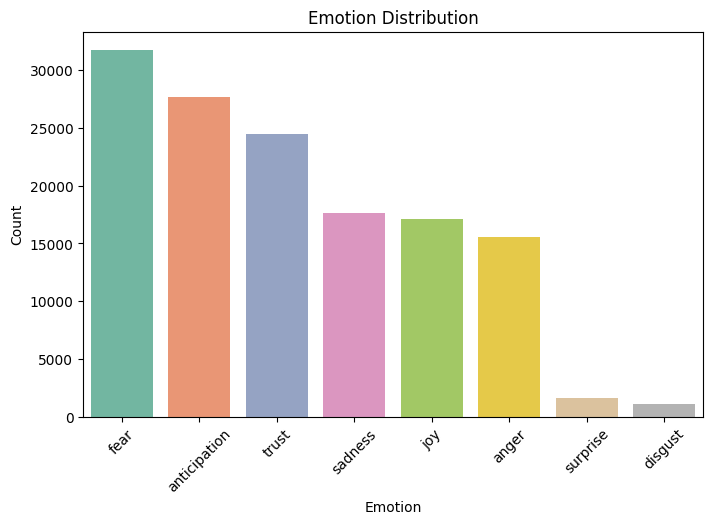

Ergebnisse gespeichert: /content/drive/MyDrive/ie_scripting_datasets/Archive/songs_with_combined_emotions.csv
                                        clean_lyrics primary_emotion  \
0  ['caught', 'ride', 'south', 'dakota', 'two', '...         sadness   
1  ['make', 'choice', 'never', 'really', 'doubt',...            fear   
2  ['instrumental', 'whole', 'world', 'already', ...           trust   
3  ['well', 'know', 'house', 'haunted', 'yeah', '...            fear   
4  ['take', 'e', 'train', 'babe', 'take', 'easy',...    anticipation   

  primary_emotion_from_features final_emotion  
0                      surprise       sadness  
1                      surprise          fear  
2                      surprise         trust  
3                      surprise          fear  
4                      surprise  anticipation  


In [18]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# **1. Daten laden**
data = pd.read_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/processed_songs_without_duplicates.csv')

# Lade das NRC Emotion Lexikon
nrc_lexicon = pd.read_csv(
    '/content/drive/MyDrive/ie_scripting_datasets/Archive/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'value']
)

# Nur relevante Einträge behalten
nrc_lexicon = nrc_lexicon[nrc_lexicon['value'] == 1]

emotion_categories = {
    'anger': ['anger'],
    'fear': ['fear'],
    'anticipation': ['anticipation'],
    'trust': ['trust'],
    'surprise': ['surprise'],
    'sadness': ['sadness'],
    'joy': ['joy'],
    'disgust': ['disgust']
}

# **2. Emotionen aus Lyrik extrahieren**
def get_emotions_and_category(tokens, lexicon, emotion_categories):
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)

    emotions = lexicon[lexicon['word'].isin(tokens)]['emotion'].values
    emotion_counts = Counter(emotions)
    category_counts = {
        category: sum(emotion_counts[emotion] for emotion in emotions_list)
        for category, emotions_list in emotion_categories.items()
    }

    is_positive = category_counts.get('joy', 0) > category_counts.get('sadness', 0)
    sentiment = 'positive' if is_positive else 'negative'

    return emotion_counts, category_counts, sentiment

results = data['clean_lyrics'].apply(
    lambda x: get_emotions_and_category(x, nrc_lexicon, emotion_categories)
)

data['emotion_counts'] = results.map(lambda x: x[0])
data['category_counts'] = results.map(lambda x: x[1])
data['primary_emotion'] = results.map(lambda x: max(x[1], key=x[1].get) if x[1] else 'neutral')

# **3. Emotionen aus Spotify-Features ableiten**
def determine_emotion_from_spotify_features(row):
    danceability = row['danceability']
    energy = row['energy']
    loudness = row['loudness']
    valence = row['valence']
    tempo = row['tempo']
    acousticness = row['acousticness']

    emotion_scores = {
        'joy': (valence * 0.4) + (danceability * 0.3) + (tempo * 0.3),
        'sadness': (1 - valence) * 0.5 + (acousticness * 0.5),
        'anger': (energy * 0.6) + (loudness * 0.4),
        'trust': (acousticness * 0.7) + (danceability * 0.3),
        'fear': (1 - energy) * 0.6 + (1 - loudness) * 0.4,
        'surprise': (tempo * 0.5) + (row['liveness'] * 0.5)
    }

    return max(emotion_scores, key=emotion_scores.get)

data['primary_emotion_from_features'] = data.apply(determine_emotion_from_spotify_features, axis=1)

# **4. Emotionen kombinieren**
def combine_emotions(lyrics_emotion, features_emotion):
    if lyrics_emotion == features_emotion:
        return lyrics_emotion
    else:
        emotion_weights = {
            'joy': 3,
            'sadness': 3,
            'anger': 2,
            'fear': 2,
            'trust': 1,
            'disgust': 1,
            'anticipation': 1,
            'surprise': 1
        }
        lyrics_weight = emotion_weights.get(lyrics_emotion, 0)
        features_weight = emotion_weights.get(features_emotion, 0)
        return lyrics_emotion if lyrics_weight >= features_weight else features_emotion

data['final_emotion'] = data.apply(
    lambda row: combine_emotions(row['primary_emotion'], row['primary_emotion_from_features']), axis=1
)

# **5. Visualisierung**
plt.figure(figsize=(8, 5))
sns.countplot(
    data=data,
    x='final_emotion',
    order=data['final_emotion'].value_counts().index,
    palette=sns.color_palette("Set2")
)
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **6. Ergebnisse speichern**
output_csv_path = '/content/drive/MyDrive/ie_scripting_datasets/Archive/songs_with_combined_emotions.csv'
data.to_csv(output_csv_path, index=False)
print(f"Ergebnisse gespeichert: {output_csv_path}")

# **7. Ergebnisse überprüfen**
print(data[['clean_lyrics', 'primary_emotion', 'primary_emotion_from_features', 'final_emotion']].head())


In [17]:
data = pd.read_csv('/content/drive/MyDrive/ie_scripting_datasets/Archive/songs_with_combined_emotions.csv')
display(data)

,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,duration_ms,lyrics,clean_lyrics,emotion_counts,category_counts,primary_emotion,primary_emotion_from_features,final_emotion
0,B Movie Box Car Blues Live,The Blues Brothers Joe Gastwirt,0.606,0.819,9,-8.281,1,0.0696,0.564000,0.004040,...,0.5040,93.307,244400,"""Caught a ride into South Dakota With two gir...","['caught', 'ride', 'south', 'dakota', 'two', '...","Counter({'positive': 4, 'sadness': 2, 'joy': 2...","{'anger': 0, 'fear': 0, 'anticipation': 0, 'tr...",sadness,surprise,sadness
1,BabyRock Rock,Clorofila,0.692,0.900,8,-7.059,1,0.0279,0.014300,0.432000,...,0.9510,126.038,280107,"""I can make a choice and never really have a ...","['make', 'choice', 'never', 'really', 'doubt',...","Counter({'negative': 6, 'positive': 5, 'fear':...","{'anger': 3, 'fear': 5, 'anticipation': 4, 'tr...",fear,surprise,fear
2,Boom,MY FIRST STORY,0.340,0.978,A,-3.785,Major,0.2090,0.000055,0.000000,...,0.1920,199.918,256000,"""Instrumental All in this whole world now has...","['instrumental', 'whole', 'world', 'already', ...","Counter({'positive': 9, 'trust': 7, 'anticipat...","{'anger': 1, 'fear': 3, 'anticipation': 6, 'tr...",trust,surprise,trust
3,Dearly Departed Live from Spotify Sxsw 2014 f...,Shakey Graves,0.561,0.491,7.0,-8.812,1.0,0.1210,0.293000,0.000001,...,0.5780,81.138,252798,"""ooo0o0oo0oo0o... ooo0o0oo0oo0o... ooo0o0oo0...","['well', 'know', 'house', 'haunted', 'yeah', '...","Counter({'negative': 9, 'fear': 7, 'positive':...","{'anger': 2, 'fear': 7, 'anticipation': 3, 'tr...",fear,surprise,fear
4,E Train,Jonny Lang,0.685,0.771,9,-7.671,1,0.0296,0.000522,0.002370,...,0.7010,112.807,251000,"""Take the ""E"" train babe take the easy train ...","['take', 'e', 'train', 'babe', 'take', 'easy',...","Counter({'positive': 5, 'joy': 2, 'anticipatio...","{'anger': 0, 'fear': 0, 'anticipation': 2, 'tr...",anticipation,surprise,anticipation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136857,caress Me Sweet,Joy Wellboy,0.536,0.613,5,-10.581,0,0.0304,0.086800,0.808000,...,0.7760,159.001,273895,"""Squeeze Caress me sweet and slam the door I...","['squeeze', 'caress', 'sweet', 'slam', 'door',...","Counter({'negative': 6, 'positive': 6, 'anger'...","{'anger': 4, 'fear': 4, 'anticipation': 4, 'tr...",anger,surprise,anger
136858,my Heart Ran Away,Joy Wellboy,0.706,0.332,5,-11.015,1,0.0289,0.366000,0.163000,...,0.4250,143.998,271578,"""Looking for it over land and sea My heart ra...","['looking', 'land', 'sea', 'heart', 'ran', 'aw...","Counter({'anger': 6, 'negative': 6, 'disgust':...","{'anger': 6, 'fear': 3, 'anticipation': 2, 'tr...",anger,surprise,anger
136859,what Baby,Joy Wellboy,0.715,0.544,4,-9.431,0,0.0296,0.028800,0.016300,...,0.3860,122.000,258090,"""When days are short and nights are long I fe...","['days', 'short', 'nights', 'long', 'feel', 'n...","Counter({'negative': 5, 'positive': 4, 'antici...","{'anger': 1, 'fear': 2, 'anticipation': 4, 'tr...",anticipation,surprise,anticipation
136860,NaN,Strangeways,0.411,0.854,6.0,-5.075,0.0,0.0371,0.052900,0.000095,...,0.5280,91.092,286280,"""You know it's wrong, you know it's right No ...","['know', 'wrong', 'know', 'right', 'sight', 's...","Counter({'negative': 6, 'fear': 5, 'anger': 4,...","{'anger': 4, 'fear': 5, 'anticipation': 3, 'tr...",fear,surprise,fear
